In [15]:
import cv2
import os
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import math 
import numpy as np
import random
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
from scipy.ndimage.measurements import label
from sklearn.preprocessing import RobustScaler

In [16]:
def retrive_data():
    sup_path = './benchmark_velocity_supp'
    folder_sup = os.listdir(sup_path)
    with open(os.path.join(sup_path,'annotation.json'),'r') as f:
        gt = json.load(f)
    f.close()
    imgs = []
    cars = []
    nocars = []
    for i in tqdm(gt):
        subset = i
        img = cv2.imread(os.path.join(sup_path,subset['file_name']))
        imgs.append(img)
        aim = subset['bbox']
        coordinates = []
        for j in aim:
            left = int(j['left'])
            top = int(j['top'])
            bottom = int(j['bottom'])
            right = int(j['right'])
            coordinates.append([(top - 32,bottom + 32),(left - 32,right + 32)])
            cars.append(img[top:bottom,left:right])
        count = 0
        while(count<25):
            h = random.randint(32,630) # prevent out of range
            v = random.randint(32,1200)
            for c in coordinates:
                if h in range(c[1][0],c[1][1]) and v in range(c[1][0],c[1][1]):
                    break
            else:
                count += 1
                nocars.append(img[h-32:h+32,v-32:v+32])
    cars = [i for i in cars if i.size]
    return imgs,cars,nocars

In [17]:
def retrive_features(cars,nocars):
    cars_resized = []
    for i in tqdm(cars):
        img_resized = cv2.resize(i,(64, 64),interpolation = cv2.INTER_CUBIC)
        cars_resized.append(img_resized)
    car_features = []
    for i in tqdm(cars_resized):
        channel1 = np.histogram(i[:, :, 0])
        channel2 = np.histogram(i[:, :, 1])
        channel3 = np.histogram(i[:, :, 2])
        hist_feature = np.concatenate((channel1[0], channel2[0], channel3[0]))
        i = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
        temp = hog(i, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=False,feature_vector=True)
        #print(type(hist_feature),hist_feature.shape,'\n',hist_feature)
        #print(type(temp),temp.shape)
        car_features.append(np.concatenate((temp,hist_feature)))
    nocars_features = []
    for i in tqdm(nocars):
        channel1 = np.histogram(i[:, :, 0])
        channel2 = np.histogram(i[:, :, 1])
        channel3 = np.histogram(i[:, :, 2])
        hist_feature = np.concatenate((channel1[0], channel2[0], channel3[0]))
        i = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
        temp = hog(i, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=False, feature_vector=True)
        nocars_features.append(np.concatenate((temp,hist_feature)))
    return car_features,nocars_features

In [18]:
def train(car_features,nocars_features):
    #print(type(car_features),len(car_features))
    #print(type(nocars_features),len(nocars_features))
    x = np.vstack((car_features, nocars_features))
    print(type(x),x.shape)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(nocars_features))))
    scaler = RobustScaler().fit(x)
    x = scaler.transform(x)
    x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)
    svc = LinearSVC()
    svc.fit(x_train, y_train)
    predict = svc.predict(x_test)
    accuracy = metrics.accuracy_score(y_test,predict)
    recall = metrics.recall_score(y_test,predict,average='macro')
    print(f"Accuracy:{accuracy:0.3f}\t Recall:{recall:0.3f}")
    print("SVM")
    print(metrics.confusion_matrix(y_test,predict))
    return svc,scaler

In [19]:
def slide_window(img, window_size=(64, 64), overlap=0.5):
    step = window_size[0] * (1 - overlap)
    number_of_window_x = int((img.shape[1] - window_size[0] * overlap) / step)
    number_of_window_y = int((500 - window_size[1] * overlap) / step)
    windows = []
    for y in range(number_of_window_y):
        for x in range(number_of_window_x):
            startx = int(x * step)
            endx = startx + window_size[0]
            starty = int(y * step) + 150
            endy = starty + window_size[1]
            # Append window position to list
            windows.append(((startx, starty), (endx, endy)))
    return windows
def search(img, windows, clf,scaler):
    result = []
    #features = []
    for window in windows:
        #print(window)
        temp = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        if temp.size:
            img_cropped = cv2.resize(temp, (64, 64))
            #print(img_cropped.shape)
            gray_img = cv2.cvtColor(img_cropped,cv2.COLOR_BGR2GRAY)
            #print(img_cropped.shape)
            temp = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=False, feature_vector=True)
            channel1 = np.histogram(img_cropped[:, :, 0])
            channel2 = np.histogram(img_cropped[:, :, 1])
            channel3 = np.histogram(img_cropped[:, :, 2])
            hist_feature = np.concatenate((channel1[0], channel2[0], channel3[0]))
            features = np.concatenate((temp,hist_feature))
#             print(type(features),features.shape)
#             print(type(temp),temp.shape)
#             print(type(hist_feature),hist_feature.shape)
            features = scaler.transform([features])
            if clf.predict(features):
                result.append(window)
    return result
def draw_windows(img,windows):
    draw_img = np.copy(img)
    for window in windows:
        cv2.rectangle(draw_img, window[0],window[1], (0, 0, 255), 3)
    return draw_img,windows

In [23]:
def read_train_data(train_path='./benchmark_velocity_train/clips/'):
    train_dirs = os.listdir(train_path)
    # Delete '.DS_Store' file in macOS system
    train_dirs = [i for i in train_dirs if i != '.DS_Store']
    clips_folders = list(map(int, train_dirs))
    clips_folders.sort()

    annotated_imgs = []
    for i in clips_folders:
        imgs_path = train_path + str(i) + '/imgs'
        for _, _, imgs in os.walk(imgs_path):
            imgs.sort()
            for img_name in imgs:
                img_path = imgs_path + '/' + img_name
                if '040' in img_name:
                    annotated_imgs.append(img_path)

    annotations = [os.path.join(train_path, str(x), 'annotation.json') for x in clips_folders]
    imgs=[]
    for i in annotated_imgs:
        imgs.append(cv2.imread(i))
    return imgs, annotations

In [25]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    plt.imshow(img)
    return img

In [20]:
imgs,cars,nocars = retrive_data()
car_features,nocars_features = retrive_features(cars,nocars)
clf,scaler = train(car_features,nocars_features)

100%|██████████| 126675/126675 [05:43<00:00, 368.67it/s]


<class 'numpy.ndarray'> (155741, 606)


/Users/caihaowen/anaconda3/envs/E9517/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy:0.961	 Recall:0.942
SVM
[[24748   714]
 [  498  5189]]


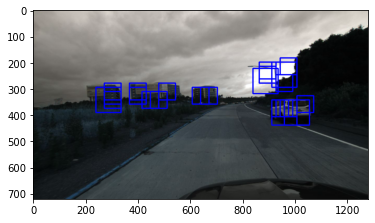

In [44]:
#imgs, annotations = read_train_data()
im = imgs[1089]
windows = []
#windows = search(im,slide_window(im),clf,scaler)
#print(windows)
#windows.extend(search(im,slide_window(im,overlap = 0.8),clf))
windows = search(im,slide_window(im,(64,64),0.75),clf,scaler)
#windows.extend(wind)
wind = search(im,slide_window(im,(96,96),0.75),clf,scaler)
windows.extend(wind)
#wind = search(im,slide_window(im,(96,96),0.5),clf,scaler)
#wind = search(im,slide_window(im,(128,128),0.25),clf,scaler)
#wind = search(im,slide_window(im,(128,128),0.75),clf,scaler)
#windows.extend(wind)
#print('wind:',wind)
draw_img,windows = draw_windows(im,windows)
plt.imshow(draw_img)

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 6)


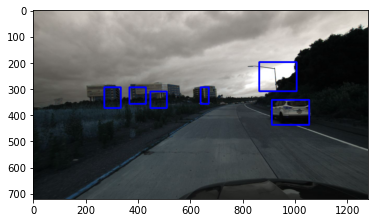

In [45]:
heat_map = np.zeros(im.shape[:2])
heat_map = add_heat(heat_map,windows)
heat_map_thresholded = apply_threshold(heat_map,1)
labels = label(heat_map_thresholded)
draw_img = draw_labeled_bboxes(im,labels)
#plt.imshow(heat_map)
print(labels)
#plt.imshow(draw_img)

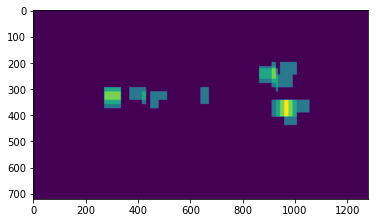

In [46]:
plt.imshow(heat_map)

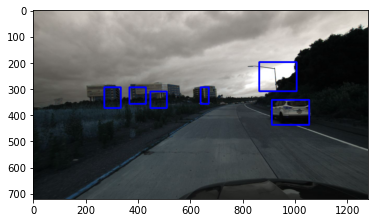

In [47]:
plt.imshow(draw_img)

In [35]:
def multi_scale_find_cars(img, svc, scaler, params, return_all=False):
    # 4个区域分别采用不同大小的比例缩放因子
    y_start_stops = [[400,464],[400,496],[432,560],[448,644]]
    x_start_stops = [[620,1000],[560,1280],[500,1280],[380,1280]]
    car_windows = []
    for i in range(len(scales)):
        scale = scales[i]
        for j in range(2):
            y_offset = j*16
            windows = search_windows(img, clf, scaler, params, y_start_stop=[y_start_stops[i][0],y_start_stops[i][1]+y_offset], xy_window=(64, 64), xy_overlap=(0.8, 0.8))
            car_windows.extend(windows)
    return np.array(car_windows)
print()